# 11장. 시퀀스 모델을 위한 합성곱 신경망과 순환 신경망

코드 열기
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/aiml4coders/blob/main/ch11/11-sequence-model.ipynb"><img src="https://jupyter.org/assets/share.png" width="61" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/aiml4coders/blob/main/ch11/11-sequence-model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

## 시퀀스 데이터를 위한 합성곱(CNN)

합성곱 신경망과 순환 신경망을 사용하여 시퀀스 데이터를 예측하는 능력을 더욱 향상시키는 기법을 학습한다.   

합성곱 신경망은 [이미지에 대해] 픽셀을 레이블에 매핑할 때 *효과적인 필터 값*을 학습한다.

이러한 과정이 시계열 데이터에도 적용 가능하다.   
**단, 합성곱을 1차원에서 수행한다.**

### 1D 합성곱 신경망 만들기

합성곱을 만들기 전 수정 사항: 윈도 데이터셋을 수정   
합성곱 층을 사용하려면, 샘플의 벡터 차원을 먼저 저장해야 한다.   
앞선 챕터에서, 윈도 데이터 셋은 샘플 차원이 하나였지만, 명시적으로 정의해두었던 것은 아니다.   
-> windowed_dataset() 함수의 첫번째 줄에 tf.expand_dims를 추가해 **차원을 정의**한다.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def plot_series, trend, seasonal_pattern, seasonality

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """임의로 정한 패턴이므로 바꿔도 좋습니다"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """기간마다 동일한 패턴을 반복합니다"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# 상수 입력
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# 시계열을 만듭니다.
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# 잡음을 추가합니다.
series += noise(time, noise_level, seed=42)

# 테스트와 검증 데이터 분리
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# 배치 상수
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

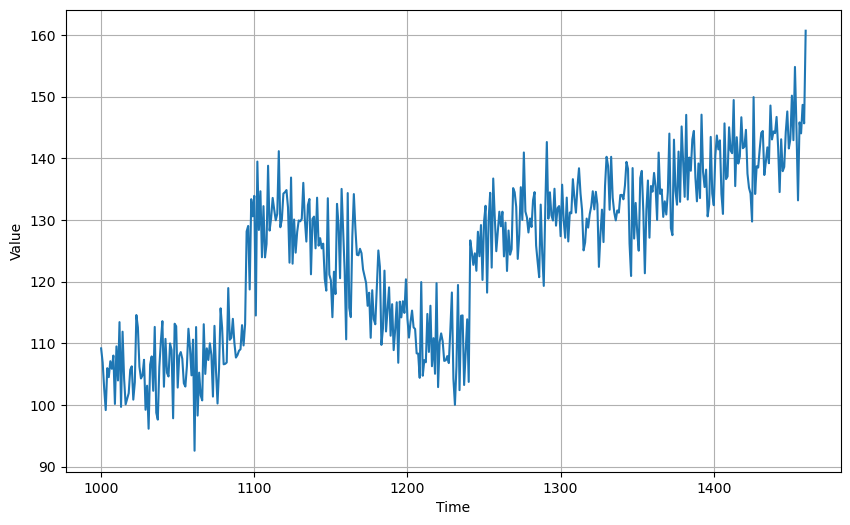

In [5]:
# 시각화
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

def windowed_dataset()

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)    # 차원 추가: 특성이 하나지만 합성곱 층이 (타임 스텝 길이, 특성 크기)의 입력을 기대하기 때문에. (np.newaxis를 사용해 차원을 늘릴 수도 있다.)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [8]:
# 데이터셋 준비
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [10]:
# filter(학습할 필터의 갯수, 필터 가중치 랜덤 설정 후 학습하면서 조정됨
# kernel_size(필터의 크기 ex.3)
# stride(필터가 입력 위를 지나갈 때 스텝 값)
# padding(가장자리 데이터 처리 방식)
# activation(활성화 함수)
# input_shape(입력층으로 들어오는 데이터 크기)
# 예를 들면, 크기가 3인 필터가 128개 랜덤 생성되어 합성곱 층 실행

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.Dense(28, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.5)   # 어제 도출한 결과로 lr 수정
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100,  verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 357.3487
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 94.7722
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 78.5893
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 72.3739
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 70.6433
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 69.0439
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 66.9301
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 67.0994
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 66.9242
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 65.8507
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 67.7821
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 67.8852
Epoch 13/100
31/31 [====

In [11]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [19]:
forecast.shape

(1442, 20, 1)

In [12]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]                  # 예측 부분만 잘라주기

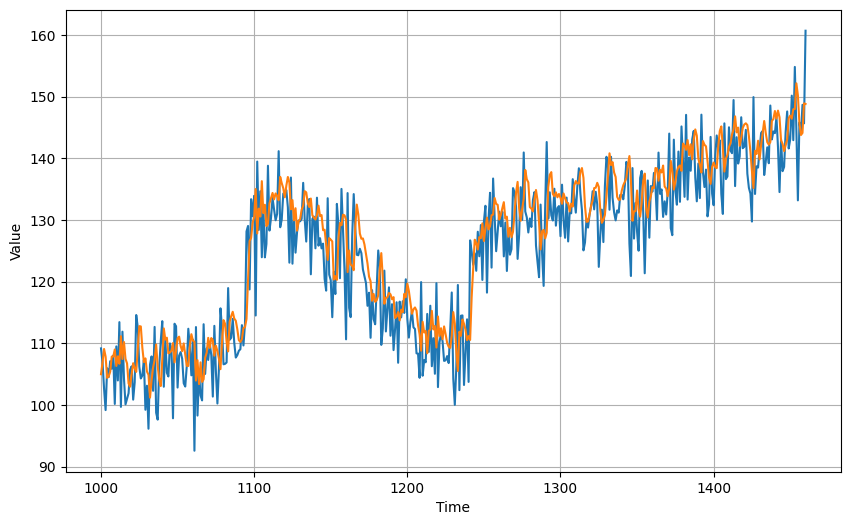

In [8]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)    # 기존 시계열 데이터
plot_series(time_valid, results)    # 예측 데이터

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.615327

### Conv1D 하이퍼파라미터 튜닝

In [20]:
%pip install keras_tuner

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [21]:
from keras_tuner.tuners import RandomSearch

<튜닝>   
keras_tuner.tuners의 RandomSearch를 사용해서   
다른 매개변수는 고정하고,    
>>필터 개수: 128부터 시작 ~ 64개씩 늘려가며 ~ 256개까지   
>>커널 크기: 3부터 시작 ~ 3개씩 늘려가며 ~ 9까지   
>>스트라이드 크기: 1부터 시작, 3까지   

이 세가지 하이퍼파라미터의 조합을 넣어서 테스트

def build_model() -> RandomSearch 매개변수

In [22]:
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                                     kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                                     strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                                     padding='causal', activation='relu', input_shape=[None, 1]))

    model.add(tf.keras.layers.Dense(28, input_shape=[window_size], activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    sgd = tf.keras.optimizers.SGD(momentum=0.5, learning_rate=1e-5)
    model.compile(loss="mse", optimizer=sgd)
    return model

tuner = RandomSearch(build_model, objective='loss', max_trials=500, 
                     executions_per_trial=3, directory='my_dir', project_name='cnn-tune')

tuner.search_space_summary()

tuner.search(dataset, epochs=100, verbose=2)

Trial 27 Complete [00h 00m 41s]
loss: 62.257240295410156

Best loss So Far: 59.88030242919922
Total elapsed time: 00h 21m 47s
INFO:tensorflow:Oracle triggered exit


In [23]:
tuner.results_summary()

Results summary
Results in my_dir\cnn-tune
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 020 summary
Hyperparameters:
units: 256
kernels: 6
strides: 1
Score: 59.88030242919922

Trial 017 summary
Hyperparameters:
units: 256
kernels: 9
strides: 1
Score: 59.92181142171224

Trial 000 summary
Hyperparameters:
units: 192
kernels: 9
strides: 1
Score: 59.922316233317055

Trial 012 summary
Hyperparameters:
units: 128
kernels: 6
strides: 1
Score: 59.95940907796224

Trial 019 summary
Hyperparameters:
units: 128
kernels: 9
strides: 1
Score: 60.00554529825846

Trial 021 summary
Hyperparameters:
units: 192
kernels: 6
strides: 1
Score: 60.1772346496582

Trial 015 summary
Hyperparameters:
units: 192
kernels: 3
strides: 1
Score: 61.337991078694664

Trial 009 summary
Hyperparameters:
units: 128
kernels: 9
strides: 2
Score: 61.49393971761068

Trial 008 summary
Hyperparameters:
units: 256
kernels: 9
strides: 2
Score: 61.55278396606445

Trial 004 summary
Hyperparameters:
units: 128


In [14]:
best_model = tuner.get_best_models(num_models=1)[0]

In [15]:
forecast = model_forecast(best_model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

46/46 [==============================] - 0s 5ms/step


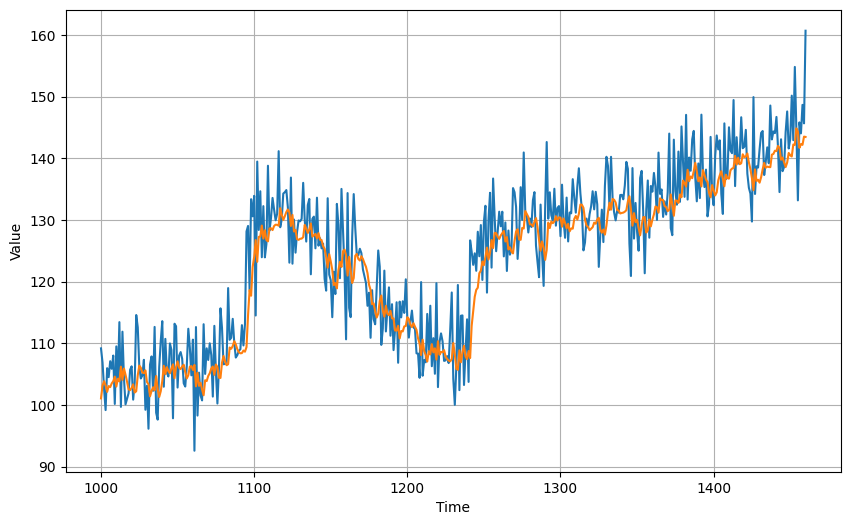

In [16]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.650504

조합의 갯수가 많기 때문에 튜닝에 시간이 많이 소요된다.   
filters를 더 작은 값에서 시작해보는 등, 다른 시도를 추천한다.   

초기 모델 설정과 비교했을 때, 필터 크기에 큰 변화가 있는 것을 확인할 수 있다.   
이는 데이터가 크기 때문에   
필터가 3일 때는 바로 이웃한 데이터로부터만 영향을 받는다.   
하지만, 필터 크기가 9가 되면 더 멀리 떨어진 데이터로부터도 영향을 받는다.   

즉, 하이퍼파라미터 탐색으로 얻은 필터 갯수와 커널 크기가 탐색 범위의 경계에 해당하기 때문에,   
범위를 더 확장하여 시도해볼 필요가 있다.

## NASA 날씨 데이터 사용하기

### 파이썬으로 GISS 데이터 읽기

##### 첫 번째 단계: 사용자 정의 함수 선언 - get_station_data()
> 1. 지정한 경로에서 파일을 열고, 전체 데이터를 한 줄로 읽는다.
> 2. 줄 바꾸는 문자(\n)로 행을 구분한다.
> 3. 첫 번째 행은 건너 뛰고, 각 행을 순회하면서   
> 4. 콤마(,)로 구분하여 리스트(linedata)에 추가   
> (이 리스트의 2~13번째 열은 1월~12월 데이터. string 값을 float으로 변환하여 temperatures 리스트에 추가.)
> 5. 리스트(temperatures)를 넘파이 배열('series')로 변환
> 6. temperatures의 길이와 동일한 크기의 넘파이배열('time')을 저장
> 7. 두 개의 넘파이 배열('series', 'time')를 리턴

* 넘파이 배열('time')   
np.arange()로 만들었기 때문에, [0, 1, ...]   


##### 두 번째 단계: 시계열 데이터를 정규화.
##### 세 번째 단계: 훈련 세트와 검증 세트로 분할, 분할 위치는 데이터 크기에 따라 선택(840개이므로 792에서 분할: 검증을 위해 4년치 데이터를 보관)
##### 네 번째 단계: 윈도 데이터셋(최종 데이터가 넘파이 배열)

In [ ]:
# %wget https://storage.googleapis.com/learning-datasets/station.csv

# VSCode에서는 터미널에서 아래 명령어 실행
# wget -o station.csv  https://storage.googleapis.com/learning-datasets/station.csv

# 참고: http://b1ix.net/182 [wget 메뉴얼]

def get_station_data()

In [25]:
# 1st 사용자 정의 함수 선언
def get_station_data():
    data_file = "station.csv"                               # 1. 데이터 불러오기
    f = open(data_file)
    data = f.read()                                             # 'data'에 할당
    f.close()

    lines = data.split('\n')                                # 2. 행 단위로 나누기
    header = lines[0].split(',')                            # 3. 첫번째 줄은 컬럼명
    lines = lines[1:]                                           # 3. 그 다음 줄부터 lines에 재할당
    temperatures=[]                                         # 4. 빈 리스트 temperature 생성

    for line in lines:
        if line:                                                # 라인이 있으면
            linedata = line.split(',')                          # 해당 라인을 ','로 구분
            linedata = linedata[1:13]                           # linedata[0]은 연도 컬럼이므로 제외하고
            for item in linedata:                               # 1월~12월을 돌면서
                if item:
                    temperatures.append(float(item))        # 4. float으로 변환해서 추가
    series = np.asarray(temperatures)                       # 5. temperature를 넘파이 배열로 변환
    time = np.arange(len(temperatures), dtype="float32")    # 6. 0에서 series길이만큼 float타입 데이터를 갖고 있는 배열 생성
    return time, series                                     # 7. 두 개의 넘파이 배열('series', 'time')를 리턴

def plot_series()

In [26]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [27]:
# time과 series 변수에 함수 실행 결과를 할당
time, series = get_station_data()

In [ ]:
# 2nd 시계열 데이터 정규화

mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

In [28]:
# 3rd 훈련 세트와 검증 세트로 분할
split_time = 792
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

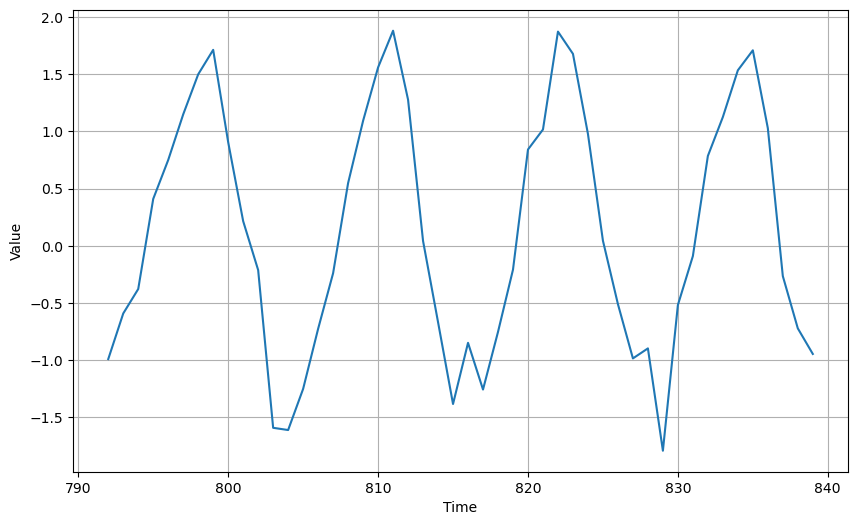

In [29]:
# 검증 데이터 시각화
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [30]:
window_size = 24
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, 
                                 batch_size, shuffle_buffer_size)

#### 다섯 번째 단계: RNN 시퀀스 모델링
#### 여섯 번째 단계: RNN 시퀀스 모델의 데이터 예측
#### 일곱 번째 단계: 실제 데이터와 예측 데이터 비교
#### 최종 단계: 손실값 확인 

## RNN으로 시퀀스 모델링하기

In [31]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(100, return_sequences=True, 
                              input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(100),
    tf.keras.layers.Dense(1)
])

In [32]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100,  verbose=1,
                    validation_data=valid_dataset)

Epoch 1/100
64/64 [==============================] - 2s 13ms/step - loss: 0.4617 - mae: 0.8731 - val_loss: 0.4644 - val_mae: 0.8674
Epoch 2/100
64/64 [==============================] - 0s 6ms/step - loss: 0.3644 - mae: 0.7560 - val_loss: 0.3723 - val_mae: 0.7503
Epoch 3/100
64/64 [==============================] - 0s 6ms/step - loss: 0.2803 - mae: 0.6461 - val_loss: 0.2938 - val_mae: 0.6437
Epoch 4/100
64/64 [==============================] - 0s 6ms/step - loss: 0.2141 - mae: 0.5520 - val_loss: 0.2312 - val_mae: 0.5509
Epoch 5/100
64/64 [==============================] - 0s 6ms/step - loss: 0.1651 - mae: 0.4756 - val_loss: 0.1844 - val_mae: 0.4731
Epoch 6/100
64/64 [==============================] - 0s 7ms/step - loss: 0.1303 - mae: 0.4157 - val_loss: 0.1491 - val_mae: 0.4184
Epoch 7/100
64/64 [==============================] - 0s 6ms/step - loss: 0.1059 - mae: 0.3718 - val_loss: 0.1229 - val_mae: 0.3792
Epoch 8/100
64/64 [==============================] - 0s 7ms/step - loss: 0.0889 - 

def model_forecast()

In [33]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [34]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

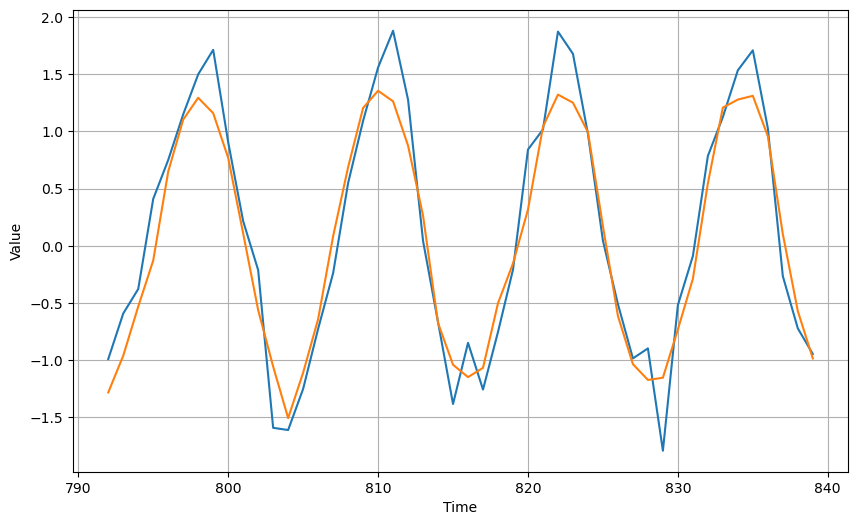

In [35]:
# 예측결과 시각화
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [36]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.2422948

>>> ※ 시계열 데이터의 특성   
(1) 트렌드, (2) 주기성 자기 상관, (3) 잡음

### 대용량 데이터셋 사용하기

In [37]:
# !wget https://storage.googleapis.com/learning-datasets/tdaily_cet.dat.txt

# 터미널
# wget -o tdaily_cet.dat.txt https://storage.googleapis.com/learning-datasets/tdaily_cet.dat.txt

#### 첫 번째 단계: 사용자 정의 함수 - get_tdaily_data()
0. !데이터 확인과정 필수!
> 1. 데이터 파일 읽기
> 2. 헤더가 없으므로 첫번째줄부터 바로 시작
> 3. 공백을 삭제: split()
> 4. 온도 데이터를 리스트(temperature)에 추가
>5. 두 개의 넘파이 배열(series, time)을 만들어 리턴

#### 두 번째 단계: 훈련 세트와 검증 세트로 분할
> 데이터 포인트: 90,663개로 구성되어 있음   
80,000을 기준으로 분할, 훈련 세트로 / 10,663개 데이터를 검증 세트로

#### 세 번째 단계: 윈도 크기, 배치 크기, 셔플 버퍼 크기 상수화

In [39]:
def get_tdaily_data():
    data_file = "tdaily_cet.dat.txt"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(' ')
            temperatures.append(float(linedata[1]))

    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")
    return time, series

In [40]:
time, series = get_tdaily_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

split_time = 80000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [41]:
# 윈도 크기, 배치 크기, 셔플 버퍼 크기 설정
window_size = 60
batch_size = 120
shuffle_buffer_size = 240

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(100, input_shape=[None, 1], return_sequences=True),
    tf.keras.layers.SimpleRNN(100), 
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100, verbose=1, validation_data=valid_dataset)

Epoch 1/100
667/667 [==============================] - 25s 37ms/step - loss: 0.1041 - mae: 0.3578 - val_loss: 0.0721 - val_mae: 0.3013
Epoch 2/100
667/667 [==============================] - 25s 38ms/step - loss: 0.0724 - mae: 0.2994 - val_loss: 0.0624 - val_mae: 0.2799
Epoch 3/100
667/667 [==============================] - 27s 40ms/step - loss: 0.0664 - mae: 0.2866 - val_loss: 0.0582 - val_mae: 0.2704
Epoch 4/100
667/667 [==============================] - 27s 41ms/step - loss: 0.0634 - mae: 0.2797 - val_loss: 0.0557 - val_mae: 0.2646
Epoch 5/100
667/667 [==============================] - 28s 41ms/step - loss: 0.0615 - mae: 0.2753 - val_loss: 0.0540 - val_mae: 0.2606
Epoch 6/100
667/667 [==============================] - 27s 40ms/step - loss: 0.0603 - mae: 0.2722 - val_loss: 0.0529 - val_mae: 0.2578
Epoch 7/100
667/667 [==============================] - 28s 42ms/step - loss: 0.0594 - mae: 0.2700 - val_loss: 0.0520 - val_mae: 0.2556
Epoch 8/100
667/667 [==============================] - 

In [42]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

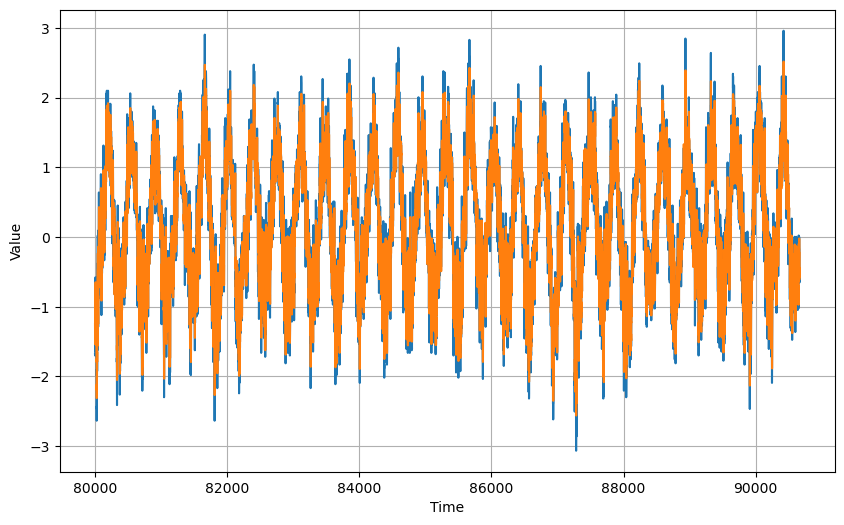

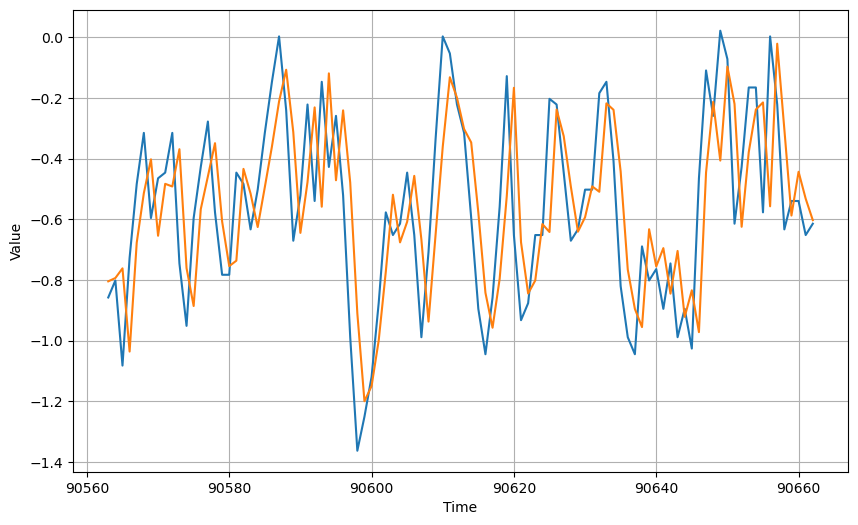

In [43]:
# 검증 세트 예측 그래프
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

# 마지막 100일치만 보면?
plt.figure(figsize=(10,6))
plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], forecast[-100:])
plt.show()

In [44]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.24214202

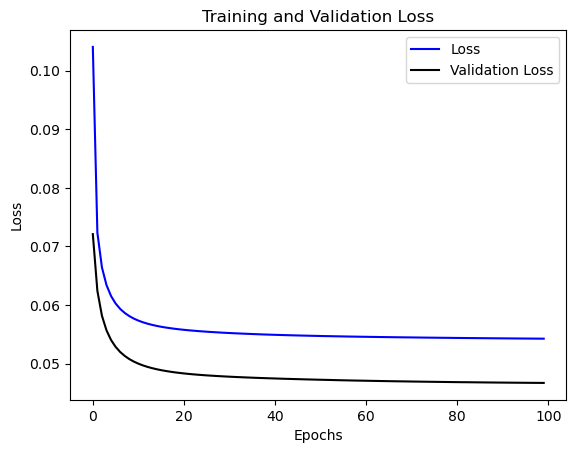

In [45]:
loss = history.history['loss']
val_mae = history.history['val_mae']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()

## Dropout 사용하기

In [39]:
time, series = get_station_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

In [40]:
split_time = 792
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [41]:
window_size = 24
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, 
                                 batch_size, shuffle_buffer_size)

In [42]:
model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, 
                        dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, validation_data=valid_dataset)

Epoch 1/500
64/64 [==============================] - 13s 136ms/step - loss: 0.4484 - mae: 0.8583 - val_loss: 0.4998 - val_mae: 0.9211
Epoch 2/500
64/64 [==============================] - 8s 123ms/step - loss: 0.4463 - mae: 0.8562 - val_loss: 0.4981 - val_mae: 0.9187
Epoch 3/500
64/64 [==============================] - 6s 96ms/step - loss: 0.4450 - mae: 0.8542 - val_loss: 0.4964 - val_mae: 0.9164
Epoch 4/500
64/64 [==============================] - 3s 54ms/step - loss: 0.4436 - mae: 0.8530 - val_loss: 0.4948 - val_mae: 0.9141
Epoch 5/500
64/64 [==============================] - 4s 55ms/step - loss: 0.4423 - mae: 0.8510 - val_loss: 0.4932 - val_mae: 0.9117
Epoch 6/500
64/64 [==============================] - 4s 55ms/step - loss: 0.4402 - mae: 0.8487 - val_loss: 0.4915 - val_mae: 0.9093
Epoch 7/500
64/64 [==============================] - 4s 56ms/step - loss: 0.4388 - mae: 0.8469 - val_loss: 0.4899 - val_mae: 0.9070
Epoch 8/500
64/64 [==============================] - 4s 55ms/step - loss:

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [43]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 1s 41ms/step


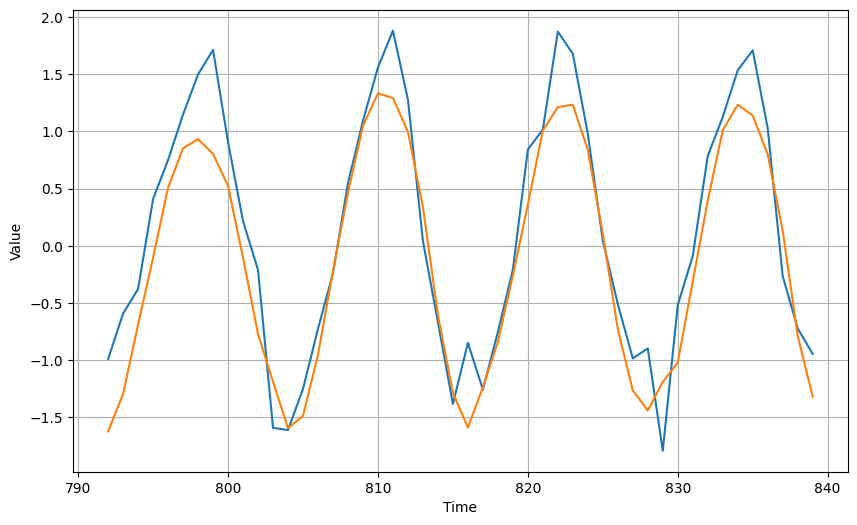

In [44]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [45]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.32309458

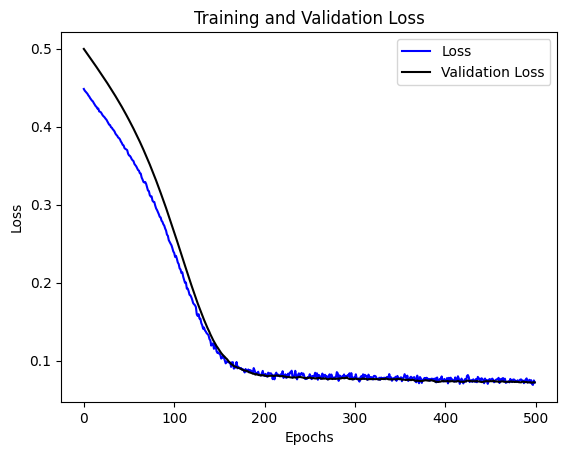

In [46]:
loss = history.history['loss']
val_mae = history.history['val_mae']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()

## 양방향 RNN 사용하기

In [47]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, input_shape=[None, 1],return_sequences=True, 
                            dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, validation_data=valid_dataset)

Epoch 1/500
64/64 [==============================] - 28s 226ms/step - loss: 0.4349 - mae: 0.8429 - val_loss: 0.4787 - val_mae: 0.9002
Epoch 2/500
64/64 [==============================] - 8s 130ms/step - loss: 0.4267 - mae: 0.8334 - val_loss: 0.4695 - val_mae: 0.8898
Epoch 3/500
64/64 [==============================] - 8s 128ms/step - loss: 0.4187 - mae: 0.8239 - val_loss: 0.4604 - val_mae: 0.8795
Epoch 4/500
64/64 [==============================] - 8s 129ms/step - loss: 0.4100 - mae: 0.8134 - val_loss: 0.4514 - val_mae: 0.8690
Epoch 5/500
64/64 [==============================] - 17s 268ms/step - loss: 0.4021 - mae: 0.8045 - val_loss: 0.4424 - val_mae: 0.8587
Epoch 6/500
64/64 [==============================] - 9s 132ms/step - loss: 0.3957 - mae: 0.7964 - val_loss: 0.4337 - val_mae: 0.8486
Epoch 7/500
64/64 [==============================] - 8s 128ms/step - loss: 0.3877 - mae: 0.7866 - val_loss: 0.4250 - val_mae: 0.8385
Epoch 8/500
64/64 [==============================] - 8s 126ms/step 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 227/500
64/64 [==============================] - 8s 126ms/step - loss: 0.0538 - mae: 0.2611 - val_loss: 0.0468 - val_mae: 0.2429
Epoch 228/500
64/64 [==============================] - 8s 129ms/step - loss: 0.0562 - mae: 0.2640 - val_loss: 0.0468 - val_mae: 0.2430
Epoch 229/500
64/64 [==============================] - 11s 178ms/step - loss: 0.0570 - mae: 0.2672 - val_loss: 0.0468 - val_mae: 0.2431
Epoch 230/500
64/64 [==============================] - 9s 132ms/step - loss: 0.0593 - mae: 0.2728 - val_loss: 0.0468 - val_mae: 0.2431
Epoch 231/500
64/64 [==============================] - 8s 131ms/step - loss: 0.0586 - mae: 0.2677 - val_loss: 0.0468 - val_mae: 0.2431
Epoch 232/500
64/64 [==============================] - 8s 126ms/step - loss: 0.0557 - mae: 0.2640 - val_loss: 0.0468 - val_mae: 0.2431
Epoch 233/500
64/64 [==============================] - 8s 127ms/step - loss: 0.0553 - mae: 0.2606 - val_loss: 0.0468 - val_mae: 0.2431
Epoch 234/500
64/64 [==============================] -

In [48]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 1s 35ms/step


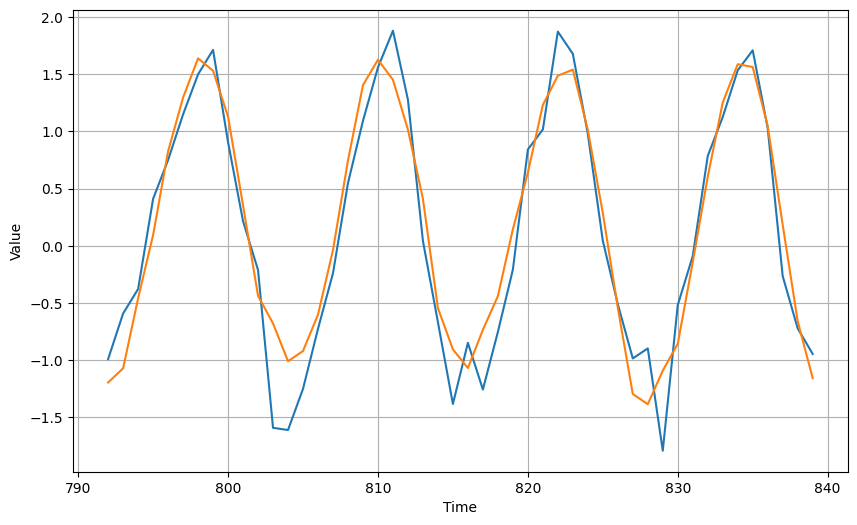

In [49]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [50]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.2585878

윈도우 크기 늘려 보기

In [51]:
window_size = 40
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, 
                                 batch_size, shuffle_buffer_size)

In [52]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, input_shape=[None, 1],return_sequences=True, 
                            dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, validation_data=valid_dataset)

Epoch 1/500
63/63 [==============================] - 37s 454ms/step - loss: 0.4698 - mae: 0.8822 - val_loss: 0.5764 - val_mae: 1.0375
Epoch 2/500
63/63 [==============================] - 13s 209ms/step - loss: 0.4645 - mae: 0.8765 - val_loss: 0.5733 - val_mae: 1.0351
Epoch 3/500
63/63 [==============================] - 25s 398ms/step - loss: 0.4614 - mae: 0.8722 - val_loss: 0.5702 - val_mae: 1.0327
Epoch 4/500
63/63 [==============================] - 14s 222ms/step - loss: 0.4571 - mae: 0.8677 - val_loss: 0.5669 - val_mae: 1.0302
Epoch 5/500
63/63 [==============================] - 13s 213ms/step - loss: 0.4542 - mae: 0.8646 - val_loss: 0.5633 - val_mae: 1.0275
Epoch 6/500
63/63 [==============================] - 25s 401ms/step - loss: 0.4502 - mae: 0.8592 - val_loss: 0.5602 - val_mae: 1.0250
Epoch 7/500
63/63 [==============================] - 13s 214ms/step - loss: 0.4468 - mae: 0.8554 - val_loss: 0.5569 - val_mae: 1.0224
Epoch 8/500
63/63 [==============================] - 24s 378ms

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



63/63 [==============================] - 14s 221ms/step - loss: 0.1810 - mae: 0.5086 - val_loss: 0.2131 - val_mae: 0.6257
Epoch 96/500
63/63 [==============================] - 14s 219ms/step - loss: 0.1708 - mae: 0.4928 - val_loss: 0.2094 - val_mae: 0.6197
Epoch 97/500
63/63 [==============================] - 20s 308ms/step - loss: 0.1722 - mae: 0.4925 - val_loss: 0.2057 - val_mae: 0.6138
Epoch 98/500
63/63 [==============================] - 14s 216ms/step - loss: 0.1665 - mae: 0.4856 - val_loss: 0.2019 - val_mae: 0.6077
Epoch 99/500
63/63 [==============================] - 17s 267ms/step - loss: 0.1663 - mae: 0.4830 - val_loss: 0.1982 - val_mae: 0.6016
Epoch 100/500
63/63 [==============================] - 24s 386ms/step - loss: 0.1639 - mae: 0.4821 - val_loss: 0.1943 - val_mae: 0.5952
Epoch 101/500
63/63 [==============================] - 14s 219ms/step - loss: 0.1566 - mae: 0.4679 - val_loss: 0.1906 - val_mae: 0.5890
Epoch 102/500
63/63 [==============================] - 20s 321ms/s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



63/63 [==============================] - 14s 216ms/step - loss: 0.0768 - mae: 0.3163 - val_loss: 0.0643 - val_mae: 0.3050
Epoch 161/500
63/63 [==============================] - 18s 290ms/step - loss: 0.0734 - mae: 0.3037 - val_loss: 0.0636 - val_mae: 0.3035
Epoch 162/500
63/63 [==============================] - 22s 344ms/step - loss: 0.0744 - mae: 0.3093 - val_loss: 0.0630 - val_mae: 0.3018
Epoch 163/500
63/63 [==============================] - 17s 272ms/step - loss: 0.0735 - mae: 0.3082 - val_loss: 0.0622 - val_mae: 0.2996
Epoch 164/500
63/63 [==============================] - 20s 306ms/step - loss: 0.0744 - mae: 0.3063 - val_loss: 0.0615 - val_mae: 0.2976
Epoch 165/500
63/63 [==============================] - 14s 217ms/step - loss: 0.0693 - mae: 0.2982 - val_loss: 0.0607 - val_mae: 0.2953
Epoch 166/500
63/63 [==============================] - 14s 217ms/step - loss: 0.0772 - mae: 0.3183 - val_loss: 0.0599 - val_mae: 0.2924
Epoch 167/500
63/63 [==============================] - 22s 338

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



63/63 [==============================] - 25s 398ms/step - loss: 0.0643 - mae: 0.2875 - val_loss: 0.0479 - val_mae: 0.2465
Epoch 203/500
63/63 [==============================] - 16s 245ms/step - loss: 0.0624 - mae: 0.2746 - val_loss: 0.0478 - val_mae: 0.2455
Epoch 204/500
63/63 [==============================] - 14s 217ms/step - loss: 0.0615 - mae: 0.2837 - val_loss: 0.0476 - val_mae: 0.2449
Epoch 205/500
63/63 [==============================] - 27s 429ms/step - loss: 0.0634 - mae: 0.2829 - val_loss: 0.0475 - val_mae: 0.2438
Epoch 206/500
63/63 [==============================] - 13s 211ms/step - loss: 0.0621 - mae: 0.2821 - val_loss: 0.0474 - val_mae: 0.2431
Epoch 207/500
63/63 [==============================] - 27s 420ms/step - loss: 0.0645 - mae: 0.2822 - val_loss: 0.0474 - val_mae: 0.2433
Epoch 208/500
63/63 [==============================] - 14s 215ms/step - loss: 0.0635 - mae: 0.2826 - val_loss: 0.0472 - val_mae: 0.2423
Epoch 209/500
63/63 [==============================] - 25s 401

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



63/63 [==============================] - 14s 221ms/step - loss: 0.0626 - mae: 0.2822 - val_loss: 0.0457 - val_mae: 0.2370
Epoch 239/500
63/63 [==============================] - 15s 242ms/step - loss: 0.0632 - mae: 0.2847 - val_loss: 0.0457 - val_mae: 0.2367
Epoch 240/500
63/63 [==============================] - 20s 310ms/step - loss: 0.0626 - mae: 0.2813 - val_loss: 0.0457 - val_mae: 0.2369
Epoch 241/500
63/63 [==============================] - 14s 219ms/step - loss: 0.0606 - mae: 0.2768 - val_loss: 0.0457 - val_mae: 0.2367
Epoch 242/500
63/63 [==============================] - 16s 261ms/step - loss: 0.0615 - mae: 0.2759 - val_loss: 0.0457 - val_mae: 0.2368
Epoch 243/500
63/63 [==============================] - 20s 307ms/step - loss: 0.0667 - mae: 0.2901 - val_loss: 0.0457 - val_mae: 0.2366
Epoch 244/500
63/63 [==============================] - 14s 218ms/step - loss: 0.0593 - mae: 0.2738 - val_loss: 0.0455 - val_mae: 0.2361
Epoch 245/500
63/63 [==============================] - 18s 286

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



63/63 [==============================] - 23s 356ms/step - loss: 0.0608 - mae: 0.2726 - val_loss: 0.0456 - val_mae: 0.2351
Epoch 303/500
63/63 [==============================] - 14s 214ms/step - loss: 0.0613 - mae: 0.2830 - val_loss: 0.0457 - val_mae: 0.2352
Epoch 304/500
63/63 [==============================] - 14s 217ms/step - loss: 0.0621 - mae: 0.2790 - val_loss: 0.0457 - val_mae: 0.2352
Epoch 305/500
63/63 [==============================] - 27s 423ms/step - loss: 0.0607 - mae: 0.2799 - val_loss: 0.0457 - val_mae: 0.2353
Epoch 306/500
63/63 [==============================] - 14s 218ms/step - loss: 0.0626 - mae: 0.2803 - val_loss: 0.0456 - val_mae: 0.2348
Epoch 307/500
63/63 [==============================] - 22s 354ms/step - loss: 0.0628 - mae: 0.2805 - val_loss: 0.0456 - val_mae: 0.2351
Epoch 308/500
63/63 [==============================] - 14s 216ms/step - loss: 0.0601 - mae: 0.2749 - val_loss: 0.0456 - val_mae: 0.2350
Epoch 309/500
63/63 [==============================] - 16s 262

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 346/500
63/63 [==============================] - 20s 314ms/step - loss: 0.0600 - mae: 0.2767 - val_loss: 0.0457 - val_mae: 0.2345
Epoch 347/500
63/63 [==============================] - 14s 219ms/step - loss: 0.0629 - mae: 0.2836 - val_loss: 0.0456 - val_mae: 0.2344
Epoch 348/500
63/63 [==============================] - 14s 216ms/step - loss: 0.0585 - mae: 0.2731 - val_loss: 0.0459 - val_mae: 0.2351
Epoch 349/500
63/63 [==============================] - 23s 373ms/step - loss: 0.0631 - mae: 0.2862 - val_loss: 0.0458 - val_mae: 0.2349
Epoch 350/500
63/63 [==============================] - 14s 219ms/step - loss: 0.0641 - mae: 0.2852 - val_loss: 0.0460 - val_mae: 0.2354
Epoch 351/500
63/63 [==============================] - 18s 289ms/step - loss: 0.0617 - mae: 0.2797 - val_loss: 0.0460 - val_mae: 0.2354
Epoch 352/500
63/63 [==============================] - 23s 365ms/step - loss: 0.0578 - mae: 0.2714 - val_loss: 0.0460 - val_mae: 0.2354
Epoch 353/500
63/63 [===========================

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



63/63 [==============================] - 15s 245ms/step - loss: 0.0589 - mae: 0.2748 - val_loss: 0.0460 - val_mae: 0.2352
Epoch 374/500
63/63 [==============================] - 20s 318ms/step - loss: 0.0597 - mae: 0.2721 - val_loss: 0.0459 - val_mae: 0.2349
Epoch 375/500
63/63 [==============================] - 14s 217ms/step - loss: 0.0591 - mae: 0.2759 - val_loss: 0.0460 - val_mae: 0.2353
Epoch 376/500
63/63 [==============================] - 16s 258ms/step - loss: 0.0589 - mae: 0.2766 - val_loss: 0.0461 - val_mae: 0.2355
Epoch 377/500
63/63 [==============================] - 20s 318ms/step - loss: 0.0589 - mae: 0.2744 - val_loss: 0.0461 - val_mae: 0.2356
Epoch 378/500
63/63 [==============================] - 14s 221ms/step - loss: 0.0626 - mae: 0.2819 - val_loss: 0.0462 - val_mae: 0.2358
Epoch 379/500
63/63 [==============================] - 14s 218ms/step - loss: 0.0596 - mae: 0.2722 - val_loss: 0.0461 - val_mae: 0.2355
Epoch 380/500
63/63 [==============================] - 25s 405

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



63/63 [==============================] - 14s 214ms/step - loss: 0.0586 - mae: 0.2698 - val_loss: 0.0465 - val_mae: 0.2363
Epoch 438/500
63/63 [==============================] - 23s 364ms/step - loss: 0.0599 - mae: 0.2772 - val_loss: 0.0463 - val_mae: 0.2358
Epoch 439/500
63/63 [==============================] - 14s 217ms/step - loss: 0.0617 - mae: 0.2831 - val_loss: 0.0463 - val_mae: 0.2359
Epoch 440/500
63/63 [==============================] - 26s 411ms/step - loss: 0.0612 - mae: 0.2781 - val_loss: 0.0465 - val_mae: 0.2363
Epoch 441/500
63/63 [==============================] - 14s 224ms/step - loss: 0.0587 - mae: 0.2742 - val_loss: 0.0464 - val_mae: 0.2361
Epoch 442/500
63/63 [==============================] - 20s 315ms/step - loss: 0.0570 - mae: 0.2658 - val_loss: 0.0464 - val_mae: 0.2361
Epoch 443/500
63/63 [==============================] - 22s 344ms/step - loss: 0.0567 - mae: 0.2706 - val_loss: 0.0462 - val_mae: 0.2355
Epoch 444/500
63/63 [==============================] - 20s 312

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



63/63 [==============================] - 13s 213ms/step - loss: 0.0567 - mae: 0.2707 - val_loss: 0.0466 - val_mae: 0.2359
Epoch 488/500
63/63 [==============================] - 14s 227ms/step - loss: 0.0587 - mae: 0.2787 - val_loss: 0.0465 - val_mae: 0.2359
Epoch 489/500
63/63 [==============================] - 19s 304ms/step - loss: 0.0583 - mae: 0.2698 - val_loss: 0.0465 - val_mae: 0.2358
Epoch 490/500
63/63 [==============================] - 14s 215ms/step - loss: 0.0574 - mae: 0.2686 - val_loss: 0.0464 - val_mae: 0.2354
Epoch 491/500
63/63 [==============================] - 16s 252ms/step - loss: 0.0583 - mae: 0.2740 - val_loss: 0.0464 - val_mae: 0.2355
Epoch 492/500
63/63 [==============================] - 25s 389ms/step - loss: 0.0602 - mae: 0.2753 - val_loss: 0.0466 - val_mae: 0.2360
Epoch 493/500
63/63 [==============================] - 13s 210ms/step - loss: 0.0625 - mae: 0.2799 - val_loss: 0.0466 - val_mae: 0.2361
Epoch 494/500
63/63 [==============================] - 17s 264

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [53]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 1s 45ms/step


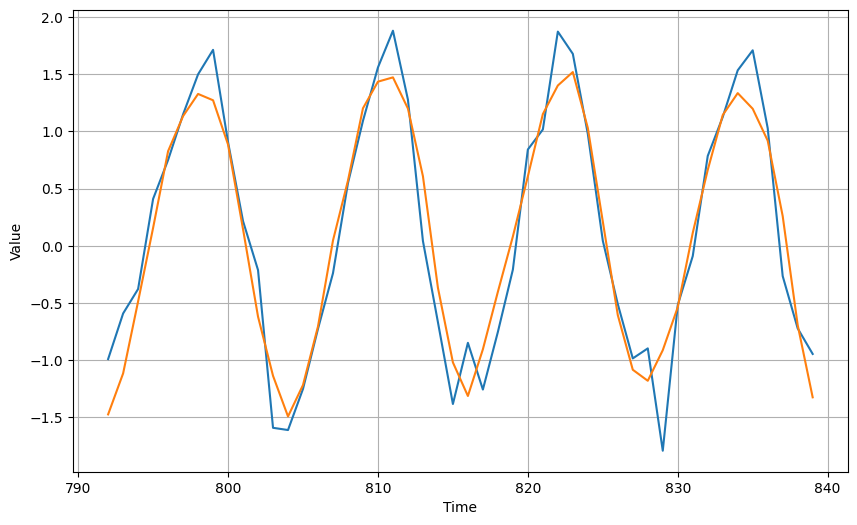

In [54]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [55]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.2417192